In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn import preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [13]:
# Reading the Airbnb-file into a dataframe
df = pd.read_csv('NYlistings.csv.gz')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51361 entries, 0 to 51360
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 41.5+ MB


In [14]:
df.columns.values.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [17]:
cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]
LISTINGSFILE = 'NYlistings.csv.gz'
# read the file into a dataframe
df = pd.read_csv(LISTINGSFILE, usecols=cols, compression='infer')

len(df.index)

51361

<AxesSubplot:>

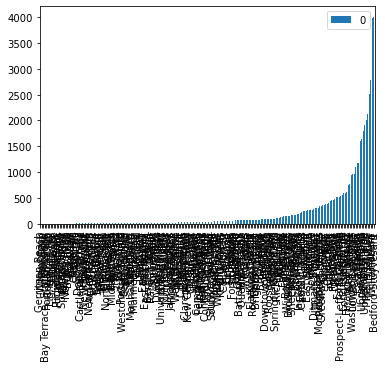

In [22]:
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

In [23]:
# the number of entries with 0 'number_of_reviews' which do not a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews == 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == False)].index)

1

In [24]:
# the number of entries with at least 1 'number_of_reviews' which have a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

0

In [25]:
# so we need to do some cleaning.

# first fixup 'reviews_per_month' where there are no reviews
df['reviews_per_month'].fillna(0, inplace=True)

# just drop rows with bad/weird values
# (we could do more here)
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

len(df.index)

35617

In [26]:
df = df[df.bedrooms == 1]
len(df.index)

27864

In [27]:
# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)

1     89.0
2    200.0
3     60.0
4     79.0
5     79.0
Name: price, dtype: float64

In [28]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Allerton,Arden Heights,...,Hotel room,Private room,Shared room,flexible,moderate,strict,strict_14_with_grace_period,super_strict_30,super_strict_60,instant_t
1,3,1.0,4.0,89.0,9,298,90.0,4.65,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,1.0,1.0,200.0,0,78,90.0,0.60,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2,1.0,1.0,60.0,0,50,90.0,0.39,0,0,...,0,1,0,0,0,0,1,0,0,0
4,2,1.0,1.0,79.0,5,459,83.0,3.53,0,0,...,0,1,0,0,0,0,1,0,0,0
5,1,1.0,1.0,79.0,0,118,98.0,0.94,0,0,...,0,1,0,1,0,0,0,0,0,0


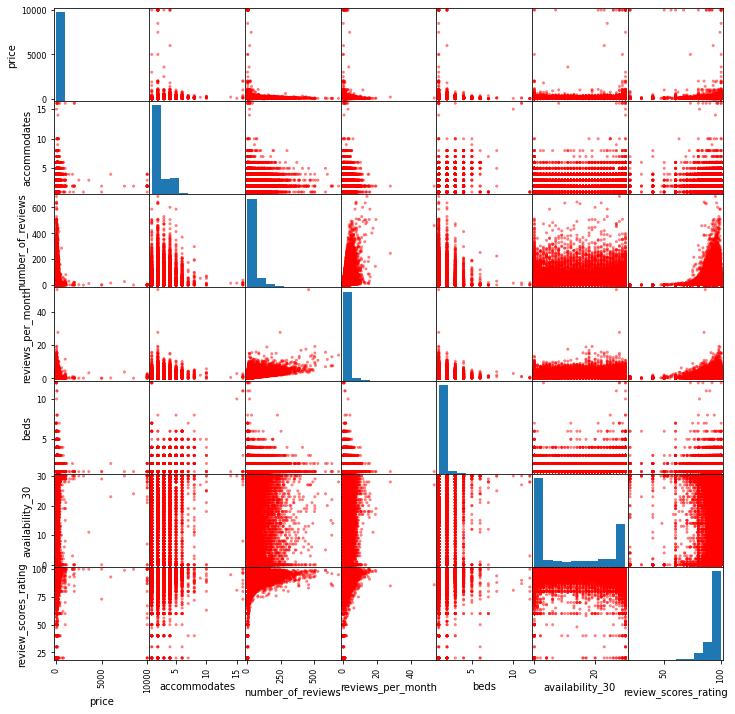

In [29]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.plotting.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')

Text(0, 0.5, 'Median Absolute Error')

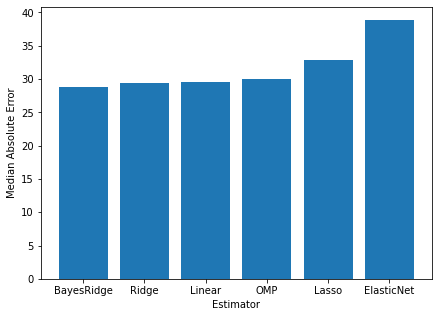

In [30]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [33]:
n_est = 300

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 2 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(learning_rate=0.01, loss='lad', max_depth=4,
                          n_estimators=300)

In [ ]:
abs(clf.best_score_)